In [1]:
import sys
import os
import glob
import shutil
import numpy as np
import cv2
import lmdb

from matplotlib import pyplot as plt
%matplotlib inline

sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
import caffe
from caffe.proto import caffe_pb2

# Random crops

In [4]:
image_source = '/home/nathan/histo-seg/semantic-pca/data/source_validate/jpg'
mask_source = '/home/nathan/histo-seg/semantic-pca/data/source_validate/mask'

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.jpg')
))

mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.png')
))

print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)


# h,w = sampleimg.shape[:2]
# print h,w

winsize = 512
scale = 4
winwrite = winsize / scale
n = 5

hlist = [cv2.imread(il).shape[0] for il in img_list]
r = lambda h: np.random.randint(h-winsize)
coords = [[(r(h), r(h)) for _ in range(n)] for h in hlist]


'''
Create an lmdb database of images

'''

image_db = '/home/nathan/histo-seg/semantic-pca/data/db/feature_test_lmdb'
mask_db = '/home/nathan/histo-seg/semantic-pca/data/db/mask_test_lmdb'
debug_dir = '/home/nathan/histo-seg/semantic-pca/data/debug'

if os.path.exists(image_db): shutil.rmtree(image_db)
if os.path.exists(mask_db): shutil.rmtree(mask_db)

safety = 10
sampleimg = cv2.imread(img_list[0])
est_total = sampleimg.nbytes * len(img_list) * safety

'''
Do the DB write
'''
env = lmdb.open(image_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(img_list, coords)):
        img = cv2.imread(img_name)
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize, :]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite))
            
            # From BVLC/caffe/issues/1698
            subimg = subimg_[:,:,::-1]
            subimg = subimg.transpose((2,0,1))
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            if index % 500 == 0:
                print str_id
                cv2.imwrite(os.path.join(debug_dir, '{}t.png'.format(str_id)), 
                            subimg_)
                
            index += 1
print 'added {} files to {}'.format(index, image_db)
env.close()

'''
Do the DB write
'''
env = lmdb.open(mask_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(mask_list, coords)):
        img = cv2.imread(img_name, 0)
#         img = img > 0
#         img.dtype = np.uint8
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite))
            subimg = np.expand_dims(subimg_, 0)
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            if index % 500 == 0:
                print str_id
                cv2.imwrite(os.path.join(debug_dir, '{}t_.png'.format(str_id)), 
                            subimg_*(255/subimg_.max()))
                
            index += 1
print 'added {} files to {}'.format(index, mask_db)
env.close()
print 'done'

Found 63 images in /home/nathan/histo-seg/semantic-pca/data/source_validate/jpg
Found 63 images in /home/nathan/histo-seg/semantic-pca/data/source_validate/mask
added 316 files to /home/nathan/histo-seg/semantic-pca/data/db/feature_test_lmdb
added 316 files to /home/nathan/histo-seg/semantic-pca/data/db/mask_test_lmdb
done


(1000, 1000)
244
0
uint16

(1000, 1000, 3)
255
0
uint8


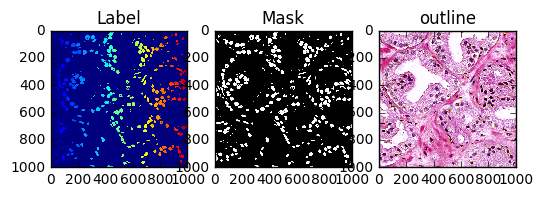

In [104]:
src = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M0XRT_2'

src_list = sorted(glob.glob(
    os.path.join(src, '*.png')
))

outline_list = [img for img in src_list if 'tif.png' in img]
mask_list = [img for img in src_list if '_mask' in img]
label_list = [img for img in src_list if 'Lmask' in img]

# image_source = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature'
# label_source = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_label'
# mask_source = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_mask'

# img_list = sorted(glob.glob(
#     os.path.join(image_source, '*.tif')
# ))

# label_list = sorted(glob.glob(
#     os.path.join(label_source, '*.png')
# ))

# mask_list = sorted(glob.glob(
#     os.path.join(mask_source, '*.png')
# ))

x = np.random.randint(len(mask_list))
label = cv2.imread(label_list[x], -1)
img = cv2.imread(outline_list[x]); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_list[x])

print label.shape
print label.max()
print label.min()
print label.dtype
print ''
print mask.shape
print mask.max()
print mask.min()
print mask.dtype

fig,ax = plt.subplots(1,3)
ax[0].imshow(label*255); ax[0].set_title('Label')
ax[1].imshow(mask); ax[1].set_title('Mask')
ax[2].imshow(img); ax[2].set_title('outline')


## If necessary do copy first

In [123]:
src = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1'
feature = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original'

feature_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature_test'
outline_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_outline_test'
mask_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_mask_test'
label_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_label_test'

src_list = sorted(glob.glob(
    os.path.join(src, '*.png')
))

feature_list = sorted(glob.glob(
    os.path.join(feature, '*.tif')
))

outline_list = [img for img in src_list if 'tif.png' in img]
mask_list = [img for img in src_list if '_mask' in img]
label_list = [img for img in src_list if 'Lmask' in img]

print feature_list[0]
print img_list[0]
print mask_list[0]
print label_list[0]

rep = lambda x: os.path.join(feature_dest, os.path.basename(x))
_ = [shutil.copyfile(img, rep(img)) for img in feature_list]
print 'Done copying originals'

rep = lambda x: os.path.join(outline_dest, os.path.basename(x.replace('.tif', '')))
_ = [shutil.copyfile(img, rep(img)) for img in img_list]
print 'Done copying outlines'

rep = lambda x: os.path.join(mask_dest, os.path.basename(x.replace('.tif_mask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in mask_list]
print 'Done copying masks'

rep = lambda x: os.path.join(label_dest, os.path.basename(x.replace('.tif_Lmask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in label_list]
print 'Done copying labels'

/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original/SP 02-4466 L3_001(5+5)_1_2.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature/SP 04-1514 1 L3_001(3+4)_2_4.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_mask.png
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_Lmask.png
Done copying originals
Done copying outlines
Done copying masks
Done copying labels
